# Redes Adversariales Generativas

Una red adversarial generativa es un mecanismo de DL no supervisado desarrollado en 2014 por el grupo de trabajo de Ian Goodfellow. La red adversarial generativa consiste de dos redes neuronales (generadora y discriminante) que compiten en un juego de engaño. Este tipo de redes aprende a generar nuevos datos usando los features extraídos del conjunto de datos de entrenamiento, estos datos son evaluados por la red discriminante al ser clasificados entre 'real' o 'fake'. El objetivo es generar datos que se parezcan tanto a los reales que el discriminador los clasifique como 'real'.

![](https://miro.medium.com/max/1838/1*5rMmuXmAquGTT-odw-bOpw.jpeg)


En el [artículo principal](https://arxiv.org/pdf/1406.2661.pdf) puede encontrar más referencias a cerca del funcionamiento de las GANs.


In [1]:
#-- Descomprimimos el dataset
# !rm -r mnist
# !unzip /content/drive/MyDrive/Colab/IntroDeepLearning_202102/mnist.zip

In [2]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

import torchvision.transforms as transforms

#--- Transformamos los datos para adaptarlos a la entrada de nuestro discriminador
data_transform = transforms.Compose([
                 transforms.Grayscale(3), #Dado que MNIST tiene un solo canal, lo cambiamos a 3 para no tener que modificar más capas en el modelo
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                 ])

#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  target = int(train_file.split('/')[3])
  if target == 8:
    Y_train.append( target )
    X_train.append( np.array(data_transform(Image.open(train_file) )))

#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

#- Tomamos unicamente el # 8
for i, test_file in enumerate(test_files):
  test = int(test_file.split('/')[3])
  if target == 8:  
    Y_test.append( target )
    X_test.append( np.array(data_transform(Image.open(test_file)) ))

#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

#-- Creamos el DataLoader
batch_size = 100

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)

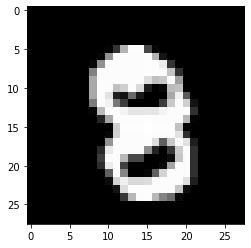

In [3]:
#-- Visualizamos uno de los objetos
import matplotlib.pyplot as plt

def denorm(x):
    out = (x + 1) / 2
    return out

for img_batch, label_batch in train_dl:
    plt.imshow(denorm(img_batch[0][0]), cmap='gray')
    break

In [4]:
#--- Seleccionamos el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
#-- Definimos input y hidden size para una red MLP
image_size = 28*28*3
hidden_size = 512

## El Discriminador

El discriminador toma una imagen como entrada. e intenta clasificarla como real o generada. El discriminador toma una imagen de tamaño (3,28,28) y lo convierte a un tensor de tamaño (1, 1 , 1).

In [6]:
import torch

#-- Definimos el discriminador
D = torch.nn.Sequential(
  torch.nn.Linear(image_size, hidden_size),
  torch.nn.LeakyReLU(0.2),
  torch.nn.Linear(hidden_size, hidden_size),
  torch.nn.LeakyReLU(0.2),
  torch.nn.Linear(hidden_size, 1),
  torch.nn.Sigmoid()
)

#-- Lo cargamos al dispositivo
D.to(device)

Sequential(
  (0): Linear(in_features=2352, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=512, out_features=1, bias=True)
  (5): Sigmoid()
)

# ReLU, ELU y LeakyReLU

La función de activación ReLU tiene algunas variantes, que cambian el valor 0 en el segmento negativo. Estas variantes permiten la relajación en la condición de activación.

![](https://www.researchgate.net/profile/Aditi-Shenoy-3/publication/334389306/figure/fig8/AS:779352161677313@1562823443351/Illustration-of-output-of-ELU-vs-ReLU-vs-Leaky-ReLU-function-with-varying-input-values.ppm)

# El generador

La entrada del generador es un vector de números aleatorios que son usados como semilla para la generación de imágenes. El generador puede convertir un tensor de tamaño (latent_size, 1 , 1) a una imagen de tamaño (3,28,28).

In [7]:
#-- Definimos el espacio latente
latent_size = 64

In [8]:
#-- Definimos el generador 
G = torch.nn.Sequential(
  torch.nn.Linear(latent_size, hidden_size),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden_size, hidden_size),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden_size, image_size),
  torch.nn.Tanh()
)

#-- Lo cargamos al dispositivo
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=2352, bias=True)
  (5): Tanh()
)

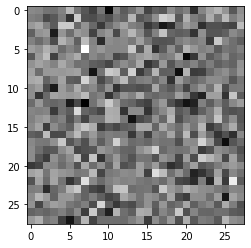

In [9]:
#--- Probamos el generador
y = G(torch.randn(2, latent_size))
gen_imgs = y.reshape((-1, 28,28)).detach()
plt.imshow(gen_imgs[0], cmap='gray')

In [10]:
# Definimos el criterio y los optimizadores para el discriminador y el generador
criterion = torch.nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [11]:
#--- Reseteamos los gradientes del discriminador y el generador
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Definimos los objetivos reales y falsos
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss para imágenes reales
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss para imágenes falsas
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combinamos las perdidas
    d_loss = d_loss_real + d_loss_fake
  
    # Backpropagation
    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

def train_generator():
    # Generamos una imagen falsa
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backpropagation
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Epoch [17/400], iter: 100, d_loss: 0.0132, g_loss: 7.5280, acc_real: 1.0000, acc_fake: 0.0131


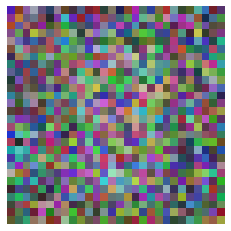



Epoch [34/400], iter: 200, d_loss: 0.0082, g_loss: 8.0747, acc_real: 0.9990, acc_fake: 0.0071


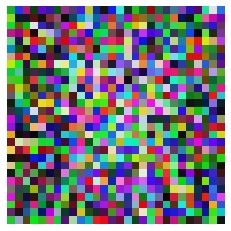



Epoch [50/400], iter: 300, d_loss: 0.0026, g_loss: 8.0442, acc_real: 0.9999, acc_fake: 0.0026


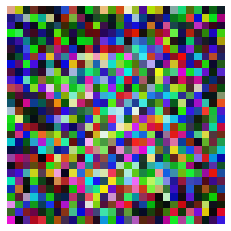



Epoch [67/400], iter: 400, d_loss: 0.0022, g_loss: 9.1789, acc_real: 0.9993, acc_fake: 0.0014


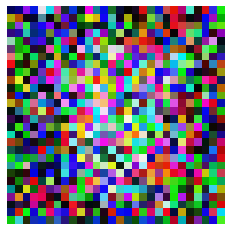



Epoch [84/400], iter: 500, d_loss: 0.0067, g_loss: 7.5790, acc_real: 0.9994, acc_fake: 0.0060


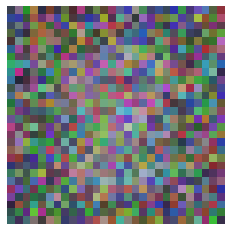



Epoch [100/400], iter: 600, d_loss: 0.0080, g_loss: 6.2852, acc_real: 1.0000, acc_fake: 0.0080


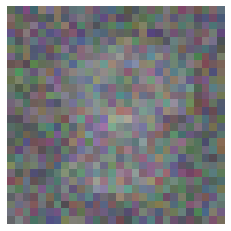



Epoch [117/400], iter: 700, d_loss: 1.4825, g_loss: 0.6739, acc_real: 1.0000, acc_fake: 0.7375


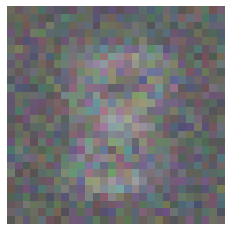



Epoch [134/400], iter: 800, d_loss: 0.0728, g_loss: 3.9897, acc_real: 1.0000, acc_fake: 0.0686


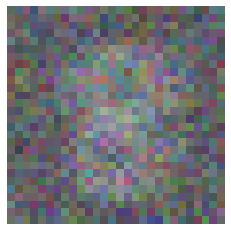



Epoch [150/400], iter: 900, d_loss: 0.0261, g_loss: 3.8086, acc_real: 0.9999, acc_fake: 0.0256


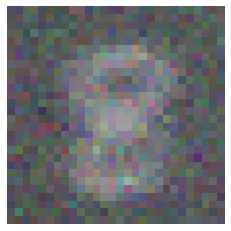



Epoch [167/400], iter: 1000, d_loss: 0.0652, g_loss: 4.1509, acc_real: 0.9994, acc_fake: 0.0621


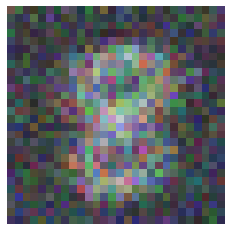



Epoch [184/400], iter: 1100, d_loss: 0.0389, g_loss: 5.7348, acc_real: 0.9895, acc_fake: 0.0270


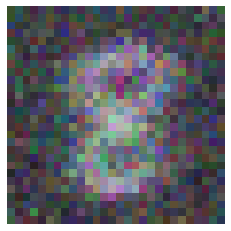



Epoch [200/400], iter: 1200, d_loss: 0.0329, g_loss: 4.9926, acc_real: 0.9930, acc_fake: 0.0251


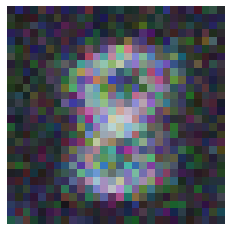



Epoch [217/400], iter: 1300, d_loss: 0.0973, g_loss: 4.6075, acc_real: 0.9997, acc_fake: 0.0876


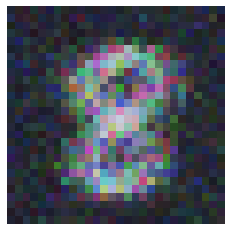



Epoch [234/400], iter: 1400, d_loss: 0.1424, g_loss: 2.8989, acc_real: 0.9526, acc_fake: 0.0771


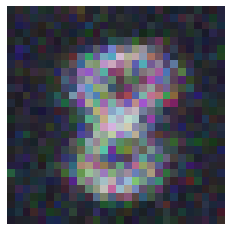



Epoch [250/400], iter: 1500, d_loss: 0.1172, g_loss: 3.7757, acc_real: 0.9792, acc_fake: 0.0881


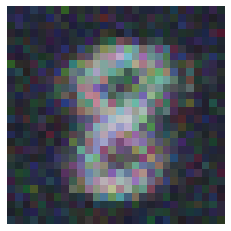



Epoch [267/400], iter: 1600, d_loss: 0.1157, g_loss: 5.3650, acc_real: 0.9996, acc_fake: 0.1044


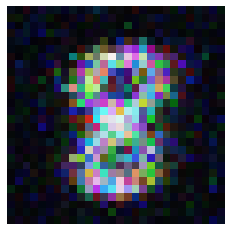



Epoch [284/400], iter: 1700, d_loss: 0.0290, g_loss: 6.5956, acc_real: 0.9969, acc_fake: 0.0253


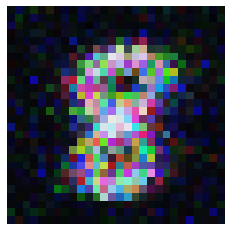



Epoch [300/400], iter: 1800, d_loss: 0.0397, g_loss: 4.3332, acc_real: 0.9906, acc_fake: 0.0294


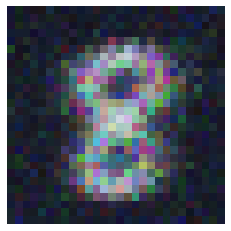



Epoch [317/400], iter: 1900, d_loss: 0.0145, g_loss: 4.3507, acc_real: 0.9976, acc_fake: 0.0120


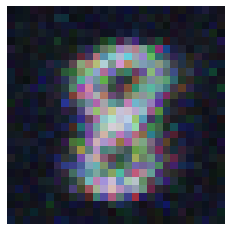



Epoch [334/400], iter: 2000, d_loss: 0.0242, g_loss: 5.1868, acc_real: 0.9981, acc_fake: 0.0221


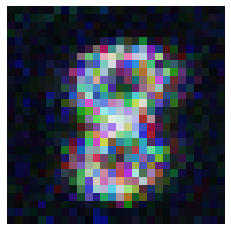



Epoch [350/400], iter: 2100, d_loss: 0.3341, g_loss: 4.7388, acc_real: 0.9925, acc_fake: 0.2560


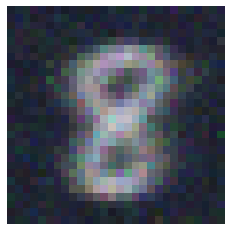



Epoch [367/400], iter: 2200, d_loss: 0.1304, g_loss: 5.9393, acc_real: 0.9786, acc_fake: 0.0894


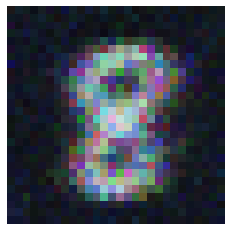



Epoch [384/400], iter: 2300, d_loss: 0.0904, g_loss: 5.6555, acc_real: 0.9875, acc_fake: 0.0670


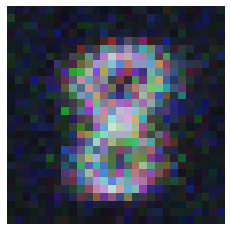



Epoch [400/400], iter: 2400, d_loss: 0.0493, g_loss: 4.1054, acc_real: 0.9862, acc_fake: 0.0339


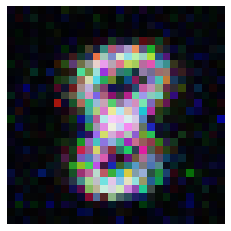

In [14]:
#-- Definimos el número de épocas
n_epoch = 400

d_losses, g_losses, accs_real, accs_fake = [], [], [], []

iter = 0

for epoch in range(n_epoch):
  for batch_id, (images, _) in enumerate(train_dl):
    
    # Load a batch & transform to vectors
    images = images.reshape(batch_size, -1).to(device)
    
    # Train the discriminator and generator
    d_loss, acc_real, acc_fake = train_discriminator(images)
    g_loss, fake_images = train_generator()
    
    # Inspect the losses
    iter +=1

    if iter % 100 == 99:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      accs_real.append(acc_real.mean().item())
      accs_fake.append(acc_fake.mean().item())
      
      print('Epoch [{}/{}], iter: {}, d_loss: {:.4f}, g_loss: {:.4f}, acc_real: {:.4f}, acc_fake: {:.4f}'
      .format(epoch+1, n_epoch, iter+1, d_loss.item(), g_loss.item(), 
              acc_real.mean().item(), acc_fake.mean().item() ))

      sample_vectors = torch.randn(batch_size, latent_size).to(device)

      fake_images = G(sample_vectors)
      fake_images = fake_images.reshape(fake_images.size(0), 3, 28, 28)

      plt.imshow(denorm(fake_images[0].detach().permute(1, 2, 0).numpy()))
      
      plt.axis(False)
      plt.show()
      print('\n')

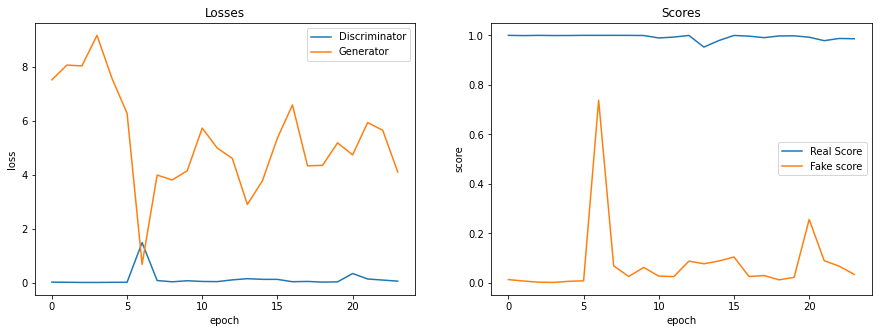

In [19]:
#-- Graficamos Loss y Accuracy
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.subplot(1,2,2)
plt.plot(accs_real, '-')
plt.plot(accs_fake, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')
plt.show()

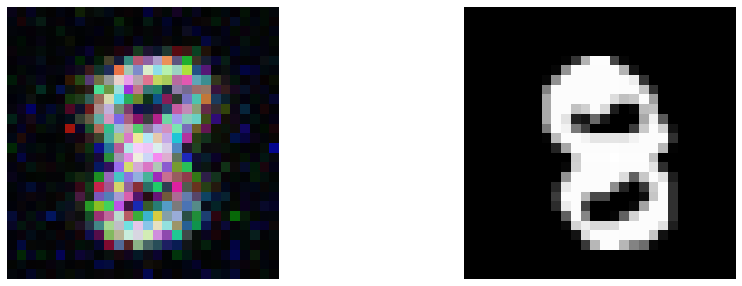

In [17]:
#-- Comparamos nuestros resultados
G.eval()
fake_images = G(sample_vectors)
fake_images = fake_images.reshape(fake_images.size(0), 3, 28, 28)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(denorm(fake_images[0].detach().permute(1, 2, 0).numpy()))
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(denorm(img_batch[0][0]), cmap='gray')
plt.axis(False)
plt.show()